In [1]:
import pickle
from qiskit_aer import AerSimulator
from qiskit import transpile
from qiskit.visualization import plot_histogram
from qiskit_aer.noise import NoiseModel, depolarizing_error, pauli_error

# Replace path in path.py with your project directory
from src.utilities.path import *

# Code import
from src.modules.povm_methods import *
from src.utilities.helpers import *
from src.utilities.crem import *

# Load one- and two-qubit SIC-POVMs 

In [2]:
# Loading POVM and vector data for SIC-POVMs in 2D and 4D spaces.
sic_4d_povm = pickle.load(open(path + "data/povms/sic_4d_povm.p", "rb"))
sic_2d_povm = pickle.load(open(path + "data/povms/sic_2d_povm.p", "rb"))

sic_4d_vectors = pickle.load(open(path + "data/povms/sic_4d_vectors.p", "rb"))
sic_2d_vectors = pickle.load(open(path + "data/povms/sic_2d_vectors.p", "rb"))

povm = sic_4d_povm

# Get circuits

In [3]:
naimark_povm_circuit = NaimarkPOVM(povm).qc
binary_povm_circuit = BinaryTreePOVM(povm).qc
hybrid_povm_circuit = HybridTreePOVM(povm).qc

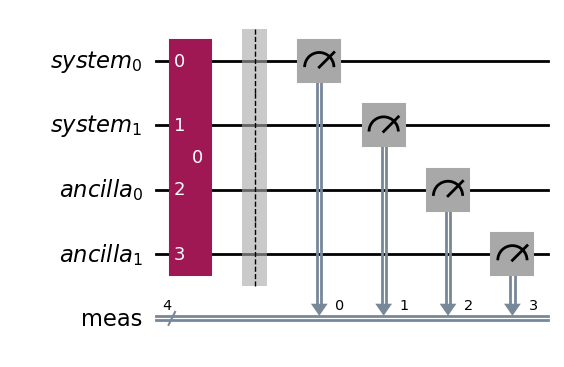

In [4]:
naimark_povm_circuit.draw('mpl')

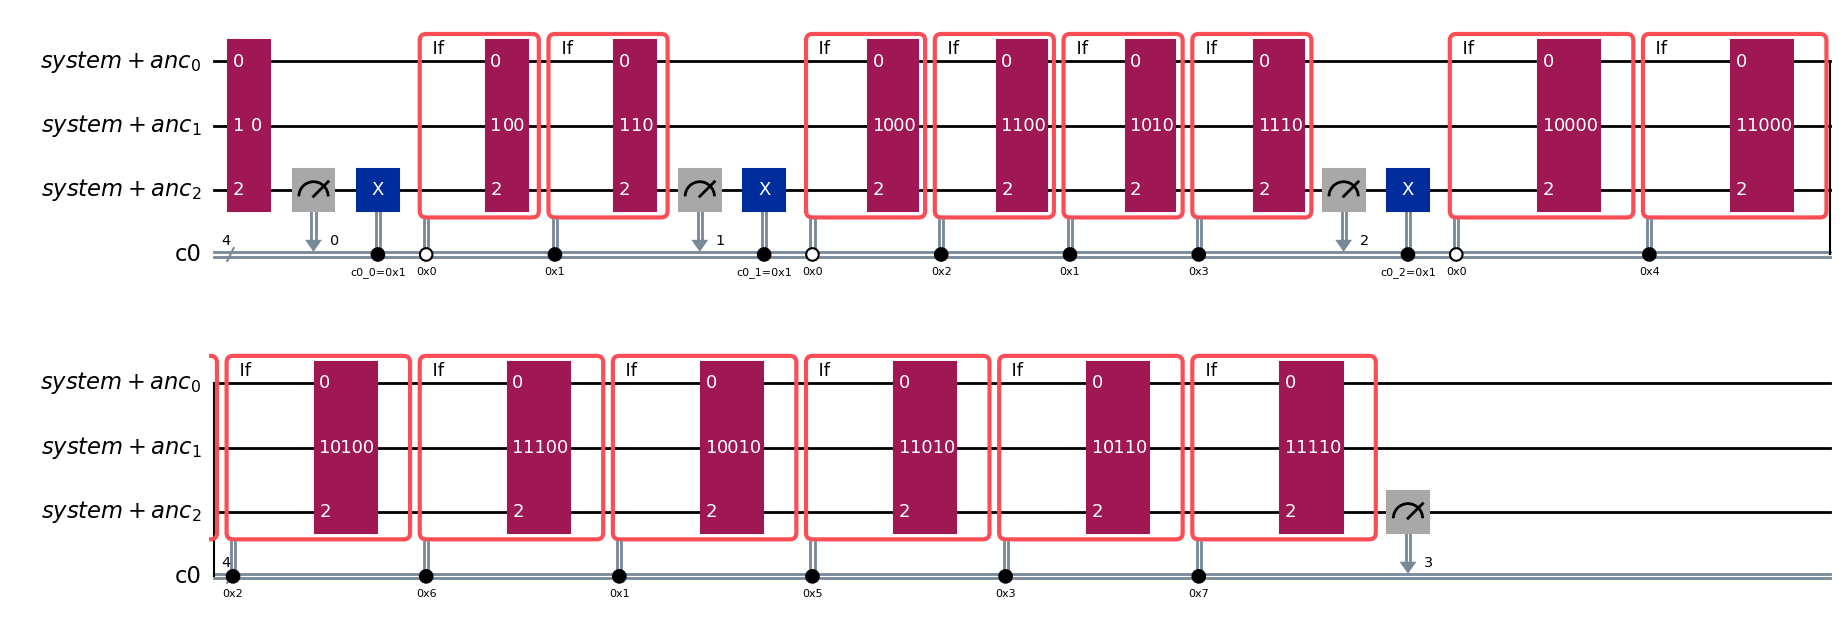

In [5]:
binary_povm_circuit.draw('mpl')

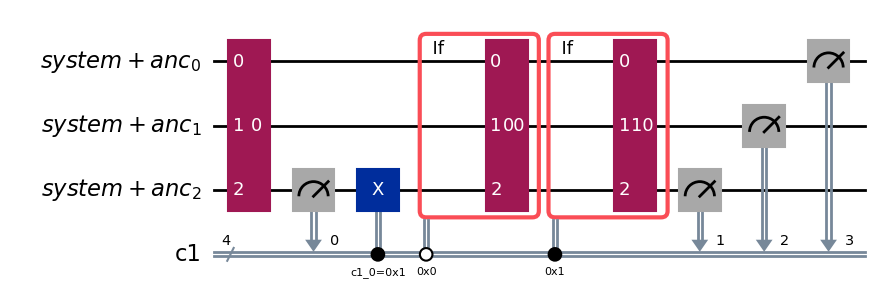

In [6]:
hybrid_povm_circuit.draw('mpl')

# Transpile circuits

In [7]:
# NOTE: Instead of exact compiling, one can use approximate compiling

naimark_povm_circuit_transpiled = transpile(naimark_povm_circuit,
                                            basis_gates=['cx', 'rz', 'sx', 'if_else', 'measure'])
binary_povm_circuit_transpiled = transpile(binary_povm_circuit,
                                           basis_gates=['cx', 'rz', 'sx', 'if_else', 'measure'])
hybrid_povm_circuit_transpiled = transpile(hybrid_povm_circuit,
                                           basis_gates=['cx', 'rz', 'sx', 'if_else', 'measure'])

# Noiseless simulation

In [8]:
cnt_theory = theoretical_probs(povm, state=np.array([1,0,0,0]))

In [9]:
cnt_naimark = AerSimulator().run(naimark_povm_circuit, shots=1e4).result().get_counts()
cnt_binary = AerSimulator().run(binary_povm_circuit, shots=1e4).result().get_counts()
cnt_hybrid = AerSimulator().run(hybrid_povm_circuit, shots=1e4).result().get_counts()

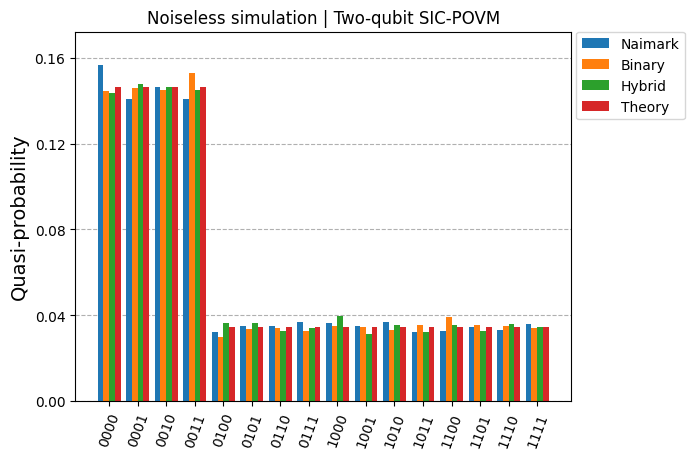

In [11]:
plot_histogram([cnt_naimark, cnt_binary, cnt_hybrid, cnt_theory], 
               legend=['Naimark', 'Binary', 'Hybrid', 'Theory'],
               title="Noiseless simulation | Two-qubit SIC-POVM",
               bar_labels=False)

# Noisy simulation

In [12]:
def noisy_simulator(e_cnot, e_meas=0):
    noise_model = NoiseModel()

    error_cnot = depolarizing_error(e_cnot, 2)
    error_meas = pauli_error([('X',e_meas), ('I', 1-e_meas)])
    
    noise_model.add_all_qubit_quantum_error(error_cnot, ['cx'])
    noise_model.add_all_qubit_quantum_error(error_meas, ['measure'])
    return AerSimulator(method='density_matrix', noise_model=noise_model)

In [13]:
e_cnot = 0.01
NoisyCNOTSimulator = noisy_simulator(e_cnot, 0)

cnt_naimark_noisy = NoisyCNOTSimulator.run(naimark_povm_circuit_transpiled, shots=1e4).result().get_counts()
cnt_binary_noisy = NoisyCNOTSimulator.run(binary_povm_circuit_transpiled, shots=1e4).result().get_counts()
cnt_hybrid_noisy = NoisyCNOTSimulator.run(hybrid_povm_circuit_transpiled, shots=1e4).result().get_counts()

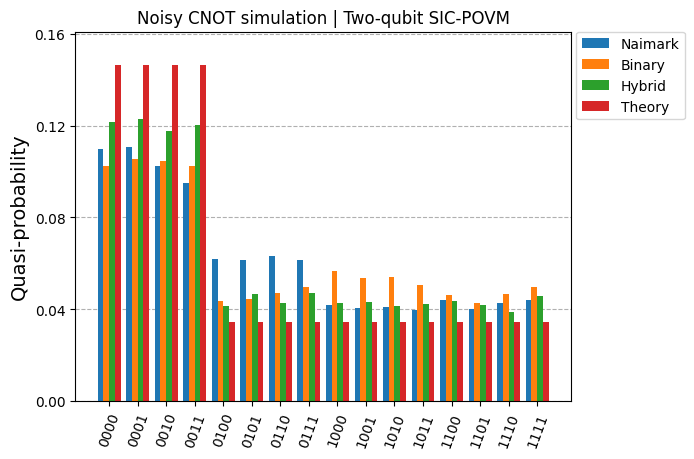

In [14]:
plot_histogram([cnt_naimark_noisy, cnt_binary_noisy, cnt_hybrid_noisy, cnt_theory], 
               legend=['Naimark', 'Binary', 'Hybrid', 'Theory'],
               title="Noisy CNOT simulation | Two-qubit SIC-POVM",
               bar_labels=False)

# Readout error mitigation

In [15]:
naimark_povm_circuit_rem = NaimarkPOVM(povm).qc
binary_povm_circuits_rem = BinaryTreePOVM(povm, conditional_calibration=True).qc
hybrid_povm_circuits_rem = HybridTreePOVM(povm, conditional_calibration=True).qc

In [16]:
shots = 1e5
e_meas = 0.1
NoisyMeasurementSimulator = noisy_simulator(0, e_meas)

cnt_naimark_noisy_meas = NoisyMeasurementSimulator.run(naimark_povm_circuit_rem, shots=1e4).result().get_counts()
cnt_binary_noisy_meas = NoisyMeasurementSimulator.run(binary_povm_circuits_rem, shots=1e4).result().get_counts()
cnt_hybrid_noisy_meas = NoisyMeasurementSimulator.run(hybrid_povm_circuits_rem, shots=1e4).result().get_counts()

In [17]:
# Simple confusion matrix for demonstration
m = np.array([[1-e_meas, e_meas], [e_meas, 1-e_meas]])

cnt_naimark_rem = rem_2q_naimark(cnt_binary_noisy_meas[0], m, m, m, m)
cnt_binary_rem = crem_2q_binary(cnt_binary_noisy_meas, m)
cnt_hybrid_rem = crem_2q_hybrid(cnt_hybrid_noisy_meas, m, m, m)

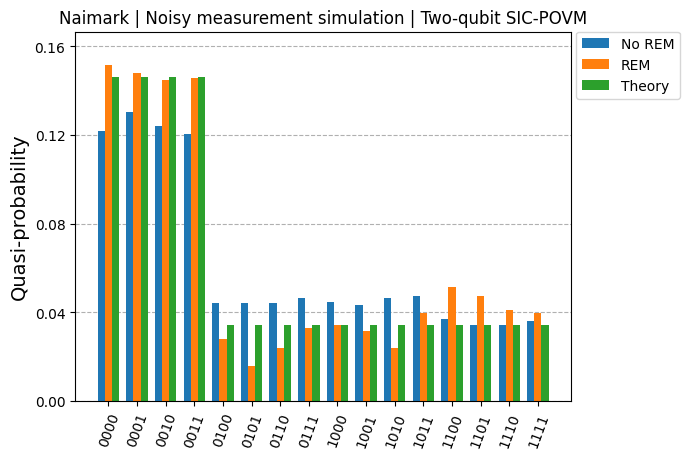

In [18]:
plot_histogram([cnt_naimark_noisy_meas, cnt_naimark_rem, cnt_theory], 
               legend=['No REM', 'REM', 'Theory'],
               title="Naimark | Noisy measurement simulation | Two-qubit SIC-POVM",
               bar_labels=False)

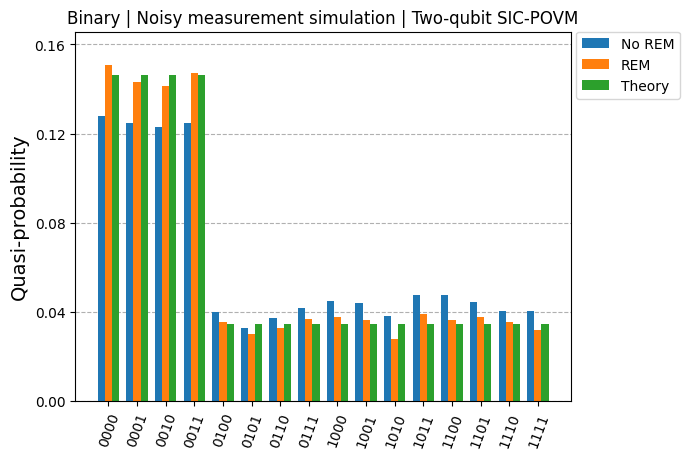

In [19]:
plot_histogram([cnt_binary_noisy_meas[0], cnt_binary_rem, cnt_theory], 
               legend=['No REM', 'REM', 'Theory'],
               title="Binary | Noisy measurement simulation | Two-qubit SIC-POVM",
               bar_labels=False)

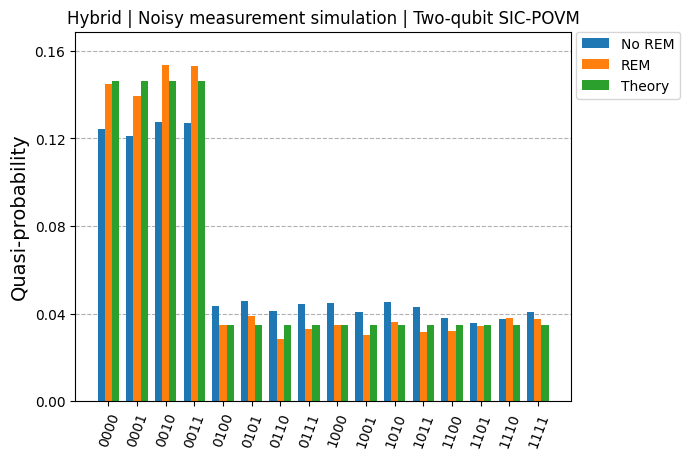

In [20]:
plot_histogram([cnt_hybrid_noisy_meas[0], cnt_hybrid_rem, cnt_theory], 
               legend=['No REM', 'REM', 'Theory'],
               title="Hybrid | Noisy measurement simulation | Two-qubit SIC-POVM",
               bar_labels=False)